Empirical CLV Analysis

This notebook calculates customer-level and cohort-level empirical CLV.
Input is cleaned customer transactions (`transactions_customers.parquet`).
Output includes CSV files and plots for further Streamlit integration.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)

1. Set paths and load data
In this section, the notebook sets the data and output paths, reads the cleaned transactions data (`transactions_customers.parquet`), converts `Customer ID` to string and `InvoiceDate` to datetime, and calculates `Amount = Quantity * UnitPrice` for each transaction.


In [21]:
DATA_DIR = Path("clean_data")
OUTPUT_DIR = Path("output_clv")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

df = pd.read_parquet(DATA_DIR / "transactions_customers.parquet")
df['Customer ID'] = df['Customer ID'].astype(str)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

df['Amount'] = df['Quantity'] * df['UnitPrice']

df[['Quantity', 'Price', 'Amount']].head(10)
df['Price'].describe()
df['Amount'].describe()

df[['Price', 'UnitPrice', 'Quantity', 'Amount']].describe()


,Price,UnitPrice,Quantity,Amount
count,1.031915e+06,1.031915e+06,1.031915e+06,1.031915e+06
mean,4.612980e+00,4.612980e+00,1.009569e+01,1.825891e+01
std,1.224639e+02,1.224639e+02,1.750244e+02,2.958455e+02
min,-5.359436e+04,-5.359436e+04,-8.099500e+04,-1.684696e+05
25%,1.250000e+00,1.250000e+00,1.000000e+00,3.750000e+00
50%,2.100000e+00,2.100000e+00,3.000000e+00,9.920000e+00
75%,4.150000e+00,4.150000e+00,1.000000e+01,1.770000e+01
max,3.897000e+04,3.897000e+04,8.099500e+04,1.684696e+05


2. Compute customer-level empirical CLV
Here, the notebook groups data by `Customer ID` and sums the `Amount` to calculate the empirical CLV for each customer, and then saves the results to `clv_customer.csv`.


In [22]:
df['Amount'] = df['Quantity'] * df['UnitPrice']

clv_customer = df.groupby('Customer ID')['Amount'].sum().reset_index()
clv_customer.rename(columns={'Amount':'CLV_empirical'}, inplace=True)
clv_customer.to_csv(OUTPUT_DIR / "clv_customer.csv", index=False)

print("Number of customers:", clv_customer.shape[0])
print("CLV summary:")
print(clv_customer['CLV_empirical'].describe())

Number of customers: 5943
CLV summary:
count    5.943000e+03
mean     3.170393e+03
std      3.587254e+04
min     -2.511109e+04
25%      3.209750e+02
50%      8.214500e+02
75%      2.140650e+03
max      2.559614e+06
Name: CLV_empirical, dtype: float64


3. Compute cohort-level CLV
This section calculates the `InvoiceMonth` and the acquisition month (`AcqMonth`) for each customer, computes the cohort age as the number of months since their first purchase, groups data by `AcqMonth` and `CohortAge` to get the average CLV per cohort, and saves the cohort-level results to `clv_cohort.csv`.


In [23]:
if 'AcqMonth' not in df.columns:
    df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
    df['AcqMonth'] = df.groupby('Customer ID')['InvoiceMonth'].transform('min')
    df['CohortAge'] = ((df['InvoiceMonth'].dt.year - df['AcqMonth'].dt.year) * 12
                       + (df['InvoiceMonth'].dt.month - df['AcqMonth'].dt.month))

clv_cohort = df.groupby(['AcqMonth','CohortAge'])['Amount'].mean().unstack().fillna(0)
clv_cohort.to_csv(OUTPUT_DIR / "clv_cohort.csv")

4. Visualizations
In this part, the notebook creates several visualizations. First, it produces a heatmap of cohort CLV over time to show how customer value evolves by cohort age. Next, it plots the cumulative revenue per cohort to understand revenue growth over time. Finally, it plots the distribution of customer-level CLV using both linear and log scales to show the spread of low-value and high-value customers and also reports the number of zero CLV customers.


4.1 Heatmap of cohort CLV

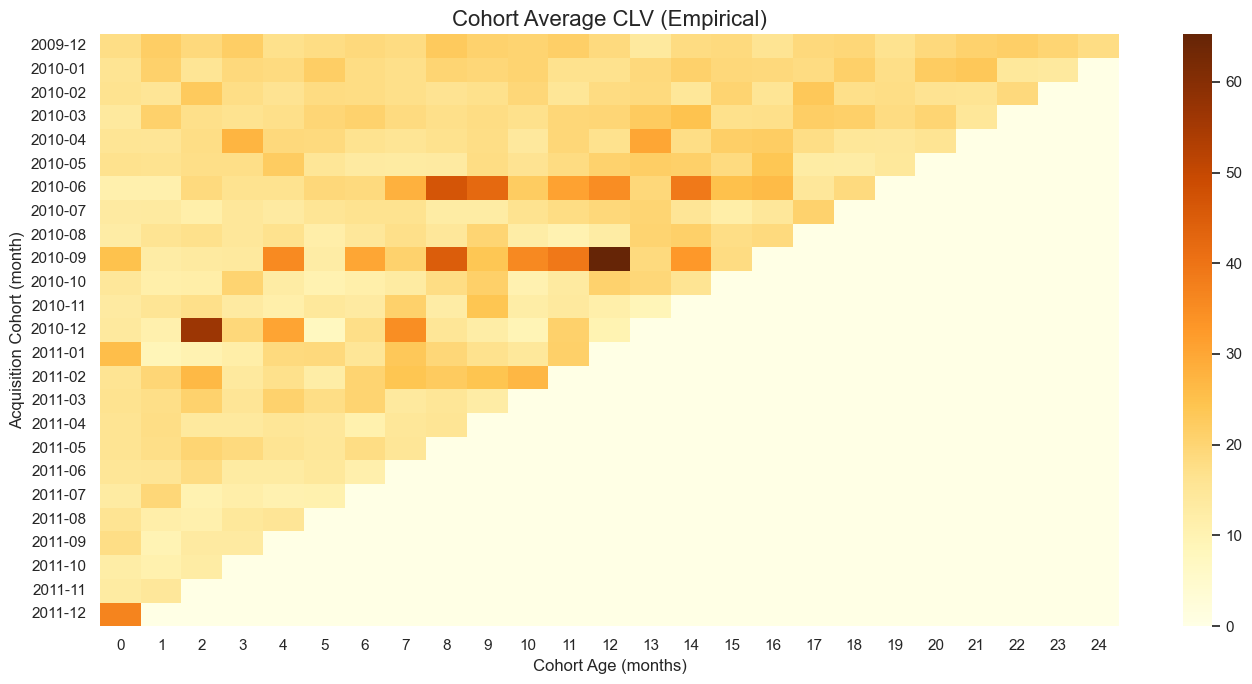

In [24]:
plt.figure(figsize=(14,7))
sns.heatmap(clv_cohort, cmap='YlOrBr', annot=False)
plt.title('Cohort Average CLV (Empirical)', fontsize=16)
plt.xlabel('Cohort Age (months)')
plt.ylabel('Acquisition Cohort (month)')
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "clv_cohort_heatmap.png", dpi=150)
plt.show()

4.2 Cumulative revenue trend per cohort

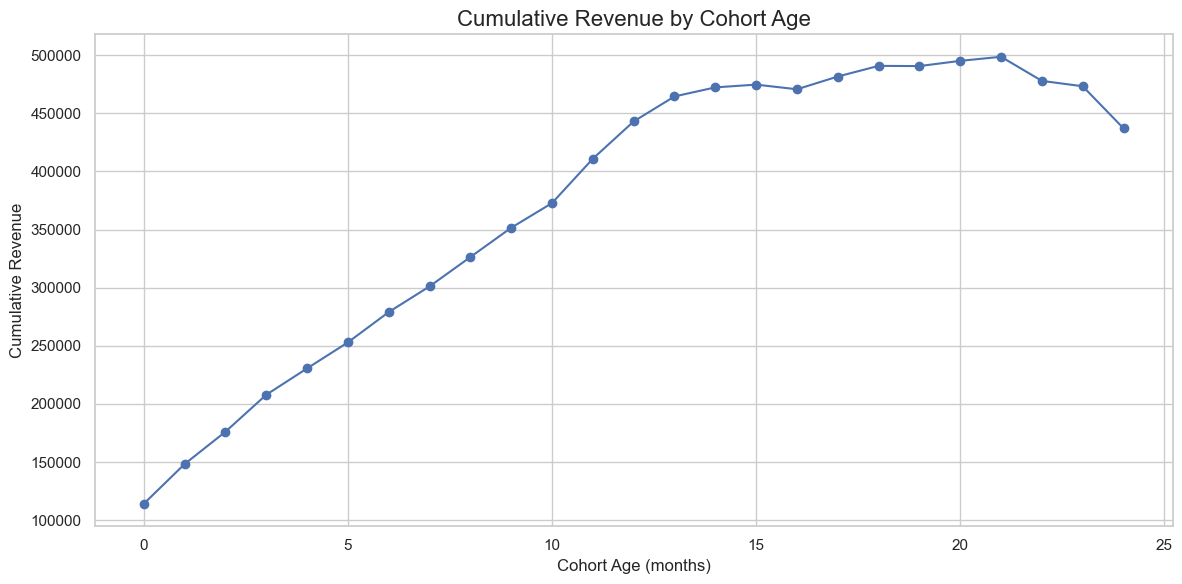

In [25]:
clv_cum = df.groupby(['AcqMonth','CohortAge'])['Amount'].sum().groupby(level=0).cumsum().unstack().fillna(0)

plt.figure(figsize=(12,6))
clv_cum.mean().plot(marker='o')
plt.title('Cumulative Revenue by Cohort Age', fontsize=16)
plt.xlabel('Cohort Age (months)')
plt.ylabel('Cumulative Revenue')
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "clv_cumulative_trend.png", dpi=150)
plt.show()


4.3 Customer-level CLV distribution

d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


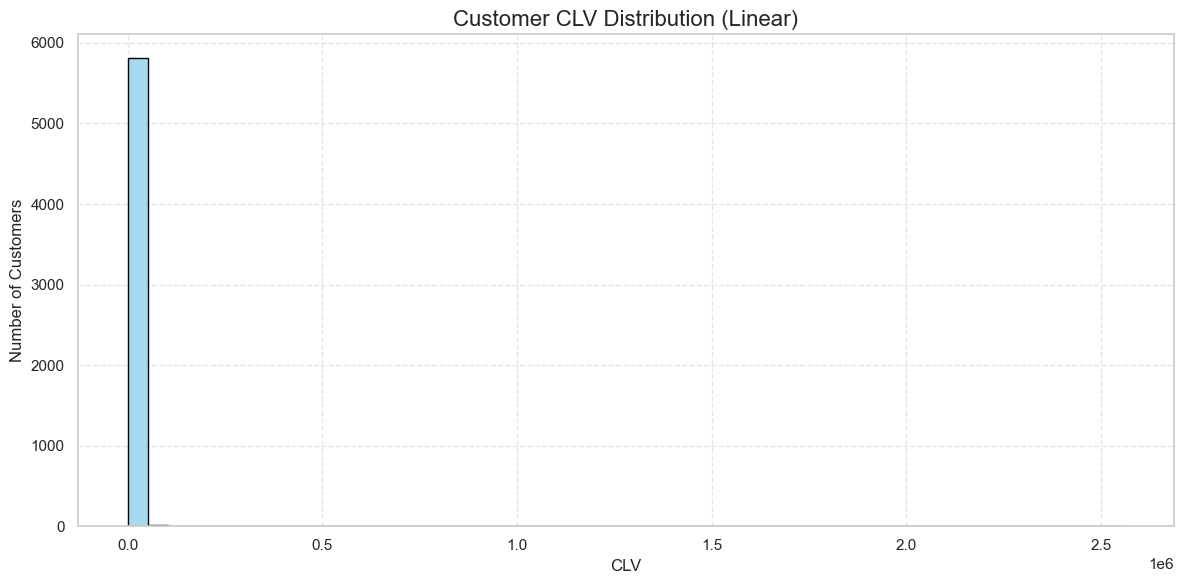

d:\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


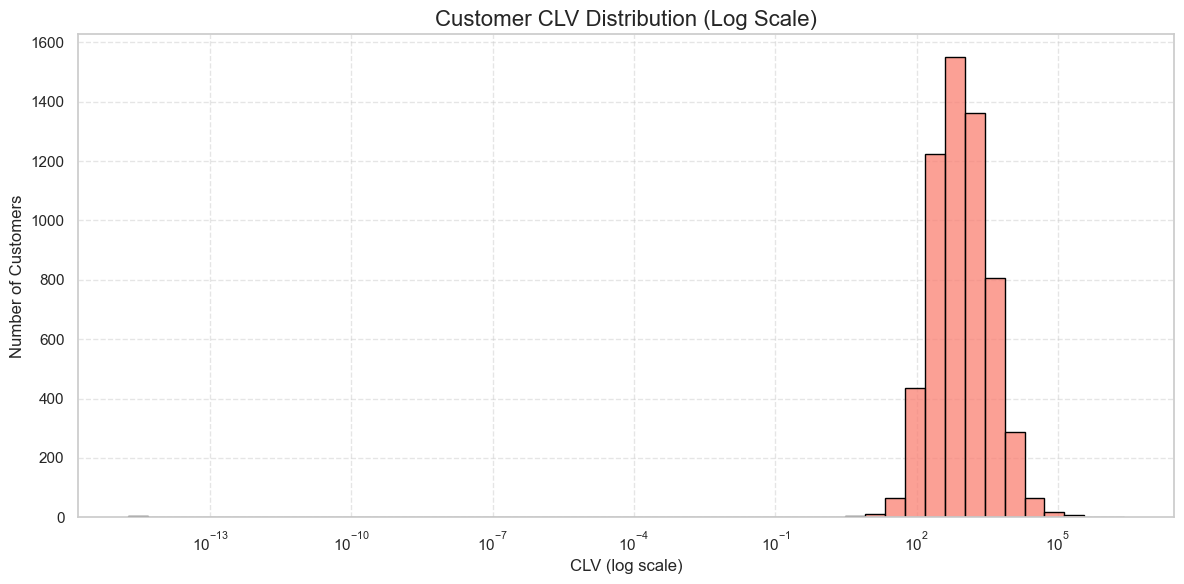

Number of zero CLV customers: 15, Percentage: 0.25%


In [26]:
# Keep only non-zero CLV customers
clv_nonzero = clv_customer[clv_customer['CLV_empirical'] > 0]

# Linear scale histogram
plt.figure(figsize=(12,6))
bins = np.linspace(clv_nonzero['CLV_empirical'].min(), clv_nonzero['CLV_empirical'].max(), 50)
sns.histplot(clv_nonzero['CLV_empirical'], bins=bins, color='skyblue', edgecolor='black')
plt.title('Customer CLV Distribution (Linear)', fontsize=16)
plt.xlabel('CLV')
plt.ylabel('Number of Customers')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "clv_customer_distribution_linear.png", dpi=150)
plt.show()

# Log scale histogram
plt.figure(figsize=(12,6))
sns.histplot(clv_nonzero['CLV_empirical'], bins=50, color='salmon', edgecolor='black', log_scale=(True, False))
plt.title('Customer CLV Distribution (Log Scale)', fontsize=16)
plt.xlabel('CLV (log scale)')
plt.ylabel('Number of Customers')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "clv_customer_distribution_log.png", dpi=150)
plt.show()

# Output zero CLV customer information
zero_count = (clv_customer['CLV_empirical'] == 0).sum()
total_count = clv_customer.shape[0]
print(f"Number of zero CLV customers: {zero_count}, Percentage: {zero_count/total_count:.2%}")

5. Summary

Customer-level CLV saved in `output_clv/clv_customer.csv`.  
Cohort-level CLV saved in `output_clv/clv_cohort.csv`.  
Visualizations saved in `output_clv/`.

This notebook completes the empirical CLV analysis and can be used as input for Streamlit application.